In [1]:
!pip install tensorflow opencv-python matplotlib

In [2]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.8.5
aiosignal                        1.3.1
alabaster                        0.7.13
albumentations                   1.2.1
altair                           4.2.2
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      21.3.0
argon2-cffi-bindings             21.2.0
array-record                     0.4.0
arviz                            0.15.1
astropy                          5.2.2
astunparse                       1.6.3
async-timeout                    4.0.2
attrs                            23.1.0
audioread                        3.0.0
autograd                         1.6.2
Babel                            2.12.1
backcall                         0.2.0
beautifulsoup4                   4.11.2
bleach                           6.0.0
blinker                          1.4
bl

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import tensorflow as tf
import os

In [5]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
tf.config.list_physical_devices('GPU')

[]

In [7]:
import cv2
import imghdr
data_dir = '/content/drive/MyDrive/DrivenByData_TeamFolder/Data'
image_exts = ['jpeg','jpg', 'bmp', 'png','webp']
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

Found 703 files belonging to 2 classes.


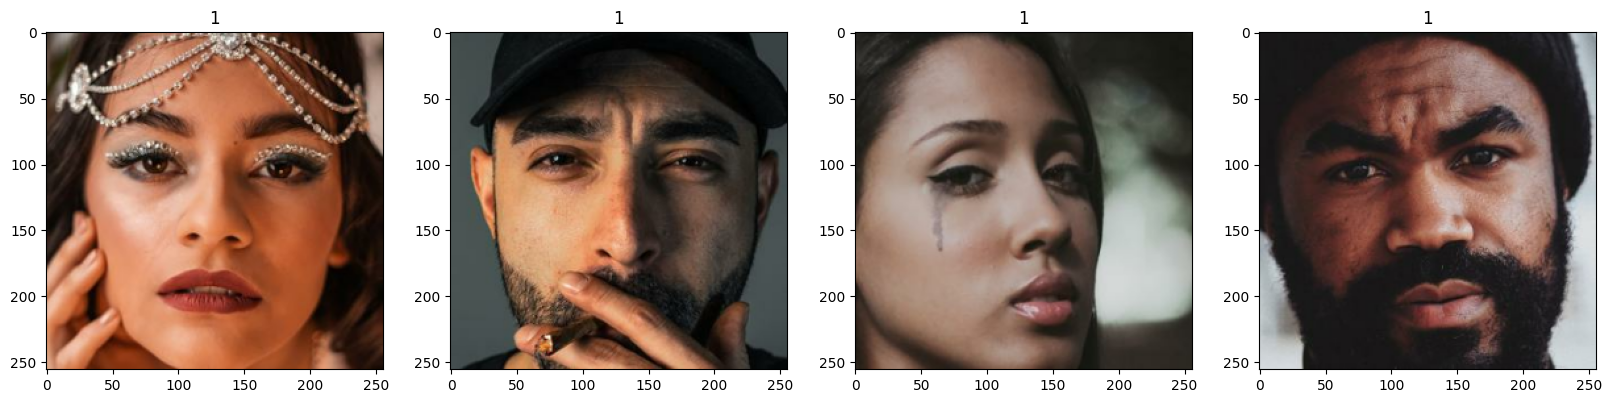

In [8]:
import numpy as np
from matplotlib import pyplot as plt
data = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/DrivenByData_TeamFolder/Data')
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [9]:
data = data.map(lambda x,y: (x/255, y))
data.as_numpy_iterator().next()

(array([[[[4.85466212e-01, 1.99256331e-01, 2.57434785e-01],
          [5.05755723e-01, 2.47774974e-01, 3.00853789e-01],
          [6.89989746e-01, 4.77974445e-01, 5.29818177e-01],
          ...,
          [9.68627453e-01, 9.84313726e-01, 9.88235295e-01],
          [9.68627453e-01, 9.84313726e-01, 9.88235295e-01],
          [9.68627453e-01, 9.84313726e-01, 9.88235295e-01]],
 
         [[5.21222055e-01, 2.68035769e-01, 3.24500233e-01],
          [5.82550883e-01, 3.53291839e-01, 4.05682027e-01],
          [8.06938887e-01, 6.25070632e-01, 6.73931539e-01],
          ...,
          [9.68627453e-01, 9.84313726e-01, 9.88235295e-01],
          [9.68627453e-01, 9.84313726e-01, 9.88235295e-01],
          [9.68627453e-01, 9.84313726e-01, 9.88235295e-01]],
 
         [[6.94000602e-01, 4.99331474e-01, 5.45209348e-01],
          [7.65752077e-01, 5.92640579e-01, 6.38590991e-01],
          [9.01998103e-01, 7.66757131e-01, 8.11721385e-01],
          ...,
          [9.68627453e-01, 9.84313726e-01, 9.8823

In [10]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)
train_size
7
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [11]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [12]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
model = Sequential()
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [13]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train, epochs=5, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/5
15/15 [==============================] - 49s 3s/step - loss: 0.3844 - accuracy: 0.8458 - val_loss: 0.2918 - val_accuracy: 0.9062
Epoch 2/5
15/15 [==============================] - 45s 3s/step - loss: 0.2023 - accuracy: 0.9333 - val_loss: 0.1328 - val_accuracy: 0.9531
Epoch 3/5
15/15 [==============================] - 43s 3s/step - loss: 0.1150 - accuracy: 0.9604 - val_loss: 0.1017 - val_accuracy: 0.9609
Epoch 4/5
15/15 [==============================] - 47s 3s/step - loss: 0.0552 - accuracy: 0.9875 - val_loss: 0.0229 - val_accuracy: 1.0000
Epoch 5/5
15/15 [==============================] - 48s 3s/step - loss: 0.0238 - accuracy: 0.9917 - val_loss: 0.0433 - val_accuracy: 0.9844


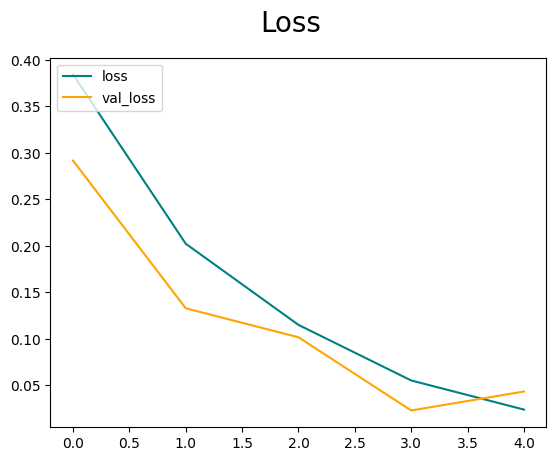

In [14]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()


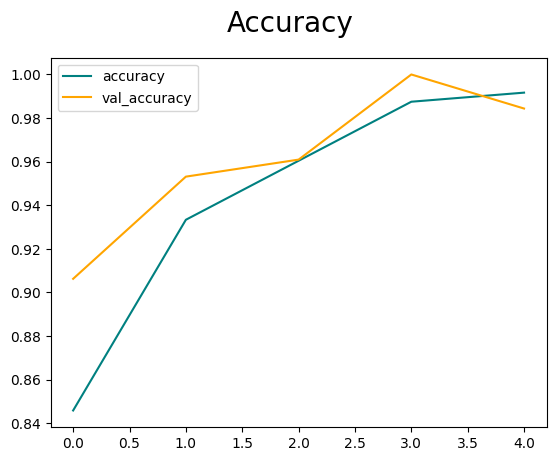

In [15]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [36]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
pre = Precision()
re = Recall()
acc = BinaryAccuracy()
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
print(pre.result(), re.result(), acc.result())

1/1 [==============================] - 1s 567ms/step
tf.Tensor(0.962963, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.96875, shape=(), dtype=float32)


In [ ]:
import cv2
img = cv2.imread('/content/drive/MyDrive/DrivenByData_TeamFolder/gettyimages-1309405076-612x612.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [49]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 37ms/step


In [ ]:
yhat

In [ ]:
if yhat > 0.5:
    print(f'Human')
else:
    print(f'Alien')

In [22]:
from tensorflow.keras.models import load_model
model.save(os.path.join('/content/drive/MyDrive/DrivenByData_TeamFolder/Models/Alien_Idenifier.h5'))

Enter PATH of image: /content/drive/MyDrive/DrivenByData_TeamFolder/gettyimages-1309405076-612x612.jpg


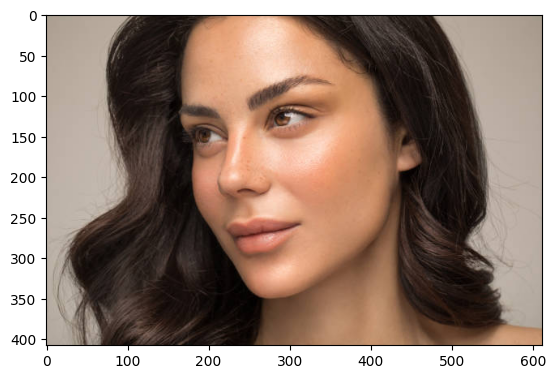

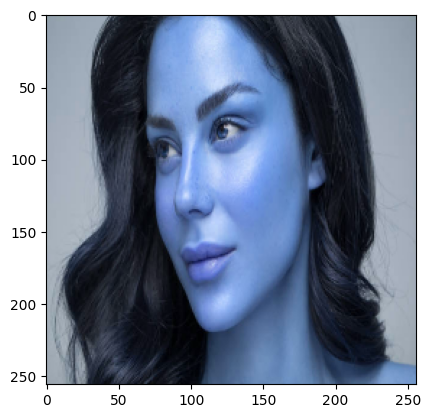

1/1 [==============================] - 0s 159ms/step
Human(s) Found!


In [55]:
img_path = str(input("Enter PATH of image: "))
new_model = load_model('/content/drive/MyDrive/DrivenByData_TeamFolder/Models/Alien_Idenifier.h5')
import cv2
new_img = cv2.imread(img_path)
plt.imshow(cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB))
plt.show()
new_resize = tf.image.resize(new_img, (256,256))
plt.imshow(new_resize.numpy().astype(int))
plt.show()
new_yhat = new_model.predict(np.expand_dims(new_resize/255, 0))
if new_yhat > 0.5:
    print(f'Human(s) Found!')
else:
    print(f'Alien(s) has been identified!')